In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fast')

from sklearn.metrics.pairwise import cosine_similarity
from src.utilities import *
from src.matrix_factorization_utilities import *

In [5]:
ratings_df = csv('https://markg110.s3-us-west-1.amazonaws.com/data/BX-Book-Ratings.csv')
books_df = csv('https://markg110.s3-us-west-1.amazonaws.com/data/BX-Books.csv')
users_df = csv('https://markg110.s3-us-west-1.amazonaws.com/data/BX-Users.csv')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/

In [6]:
print('ratings_df: ', ratings_df.shape)
print('users_df: ', users_df.shape)
print('books_df: ', books_df.shape)

ratings_df:  (1149780, 3)
users_df:  (278858, 3)
books_df:  (271360, 8)


In [7]:
ratings_df.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [8]:
users_df.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [9]:
books_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [10]:
columns = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L']
books_df.drop(columns=columns, inplace=True)

In [11]:
books_df.rename(columns={'Year-Of-Publication':'Publication-Year'},inplace=True)
books_df.drop(columns='Publisher',inplace=True)

In [12]:
books_ratings_df = pd.merge(ratings_df, books_df, on='ISBN')

In [13]:
print(books_ratings_df.shape)
print('===========================================================')
books_ratings_df.head()

(1031136, 6)


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publication-Year
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002


In [14]:
books_ratings_df = books_ratings_df[books_ratings_df['Publication-Year'] != 'Gallimard']
books_ratings_df = books_ratings_df[books_ratings_df['Publication-Year'] != 'DK Publishing Inc']

In [15]:
books_ratings_df['Publication-Year'] = books_ratings_df['Publication-Year'].apply(lambda x: int(x))

In [16]:
books_ratings_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publication-Year
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002


In [17]:
# Average ratings and number of ratings (or ratings count)
average_count_rating = pd.DataFrame(books_ratings_df.groupby('ISBN')['Book-Rating'].mean())

In [18]:
average_count_rating['Rating-Count'] = pd.DataFrame(books_ratings_df.groupby('ISBN')['Book-Rating'].count())

In [19]:
average_count_rating.rename(columns={'Book-Rating':'Average-Rating'},inplace=True)

In [20]:
print(average_count_rating.shape)
print('')
print('============================')
print('average_count_rating :::::::')
print('============================')
average_count_rating.sort_values('Rating-Count', ascending=False).head()

(270148, 2)

average_count_rating :::::::


,Average-Rating,Rating-Count
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


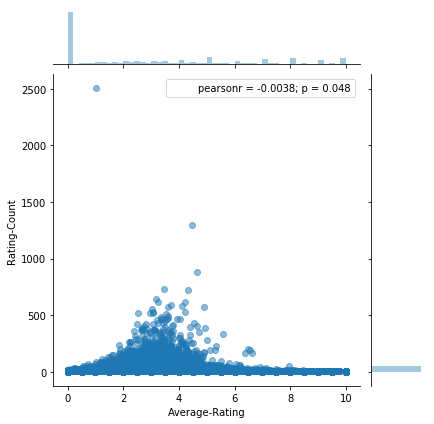

In [21]:
# Getting scatter plot between Average-Rating and Rating-Count
sns.jointplot(x = 'Average-Rating', y = 'Rating-Count', alpha=0.5, data=average_count_rating);

## Recommendations Based on Most Rated Movies

In [22]:
# Step 1: Sort by Rating-Count
test10=average_count_rating.sort_values(by='Rating-Count', ascending=False).head(10)
test10

,Average-Rating,Rating-Count
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723
044023722X,3.187017,647
0142001740,4.219512,615
067976402X,3.255700,614
0671027360,3.718430,586


In [23]:
top_isbn=test10.index.to_list()
top_isbn

['0971880107',
 '0316666343',
 '0385504209',
 '0060928336',
 '0312195516',
 '044023722X',
 '0142001740',
 '067976402X',
 '0671027360',
 '0446672211']

In [24]:
most_rated = pd.DataFrame(top_isbn, index=np.arange(len(top_isbn)), columns=['ISBN'])
most_rated_books = pd.merge(most_rated, books_ratings_df, on='ISBN')

In [25]:
top_book_titles = most_rated_books['Book-Title'].value_counts().to_frame()
top_book_titles.rename(columns={'Book-Title':'Count'},inplace=True)
top_book_titles

,Count
Wild Animus,2502
The Lovely Bones: A Novel,1295
The Da Vinci Code,883
Divine Secrets of the Ya-Ya Sisterhood: A Novel,732
The Red Tent (Bestselling Backlist),723
A Painted House,647
The Secret Life of Bees,615
Snow Falling on Cedars,614
Angels &amp; Demons,586
Where the Heart Is (Oprah's Book Club (Paperback)),585


## Recommendations Based on Correlation (Pearson R)

In [26]:
print(average_count_rating.shape)
print('')
average_count_rating.head()

(270148, 2)



,Average-Rating,Rating-Count
ISBN,,
0000913154,8.0,1
0001010565,0.0,2
0001046438,9.0,1
0001046713,0.0,1
000104687X,6.0,1


In [27]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [28]:
counts1 = ratings_df['User-ID'].value_counts()
counts2 = ratings_df['Book-Rating'].value_counts()

In [29]:
# Filtering out ratings_df by publication year is not advisable
ratings = ratings_df[ratings_df['User-ID'].isin(counts1[counts1 >= 200].index)] 
print(ratings.shape)
print('')
ratings.head()

(527556, 3)



,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [30]:
ratings = ratings[ratings['Book-Rating'].isin(counts2[counts2 >= 100].index)]
print(ratings.shape)
print('')
ratings.head()

(527556, 3)



,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [31]:
book_matrix = pd.pivot_table(ratings, index='User-ID', columns='ISBN', values='Book-Rating')
print(book_matrix.shape)
print('')
book_matrix.head()

(905, 207699)



ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,Ô½crosoft
User-ID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
book_matrix.isna().sum()

ISBN
 0330299891       904
 0375404120       903
 0586045007       904
 9022906116       903
 9032803328       904
 9044922564       904
 9044922572       904
 9044922718       904
 9044923161       904
 904492401X       904
 9061002273       904
*0515128325       904
+0451197399       904
0 00 612183 7     904
0 00 614494 2     904
0 7336 1053 6     904
0 907 062 008     904
0*708880258       904
0.330241664       904
00000000          904
000000000         902
0000000000        903
00000000000       903
000000000000      904
0000000000000     904
0000000029841     903
0000000030670     904
0000000033220     904
0000000051        904
0000001042283     904
                 ... 
O67174142X        903
O774037474        904
O77O428452        903
O786001690        904
O805063196        904
O856856428        904
O861366301        904
O880015152        904
O889950962        904
O9088446X         904
PS3569E84K5       904
Q380708353        904
Q912838027        904
SBN67001026X      904
T1101

In [33]:
ratings.sample(10)

,User-ID,ISBN,Book-Rating
1025631,245827,0684855380,8
774628,187517,0373242441,0
245948,56399,0755100697,10
790584,190925,0515131563,0
173936,37712,0688009387,0
937999,227447,0373709390,0
7464,278418,0590955993,0
860582,208141,0895770458,0
304717,72992,2253150223,0
88816,19664,014028009X,0


In [40]:
user_rating = book_matrix['0316666343']
print(user_rating.shape)
print('')
user_rating.head()

(905,)



User-ID
254     NaN
2276    NaN
2766    9.0
2977    NaN
3363    0.0
Name: 0316666343, dtype: float64

In [42]:
similar_to_user_rating = book_matrix.corrwith(user_rating)
similar_to_user_rating.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


ISBN
 0330299891   NaN
 0375404120   NaN
 0586045007   NaN
 9022906116   NaN
 9032803328   NaN
dtype: float64

In [43]:
correlated_books = pd.DataFrame(similar_to_user_rating, columns=['pearsonR'])
correlated_books.head()

,pearsonR
ISBN,
0330299891,NaN
0375404120,NaN
0586045007,NaN
9022906116,NaN
9032803328,NaN


In [44]:
correlated_books.dropna(inplace=True)

In [45]:
correlated_books.head()

,pearsonR
ISBN,
0002005018,9.614813e-18
0002184974,1.000000e+00
0002250810,1.000000e+00
000225929X,1.000000e+00
0006127754,-1.000000e+00


In [46]:
average_count_rating.head()

,Average-Rating,Rating-Count
ISBN,,
0000913154,8.0,1
0001010565,0.0,2
0001046438,9.0,1
0001046713,0.0,1
000104687X,6.0,1


In [47]:
correlation_summary = correlated_books.join(average_count_rating['Rating-Count'])

In [48]:
correlation_summary.head()

,pearsonR,Rating-Count
ISBN,,
0002005018,9.614813e-18,14.0
0002184974,1.000000e+00,2.0
0002250810,1.000000e+00,3.0
000225929X,1.000000e+00,4.0
0006127754,-1.000000e+00,NaN


In [49]:
correlation_summary[correlation_summary['Rating-Count'] >= 300].sort_values('pearsonR', ascending=False).head(10)

,pearsonR,Rating-Count
ISBN,,
0316666343,1.000000,1295.0
0312291639,0.471872,354.0
0316601950,0.434248,568.0
0446610038,0.429712,391.0
0446672211,0.421478,585.0
0385265700,0.351635,319.0
0345342968,0.316922,321.0
0060930535,0.309860,494.0
0375707972,0.308145,354.0


In [50]:
isbn_only = correlation_summary[correlation_summary['Rating-Count'] >= 300].sort_values('pearsonR', ascending=False).head(11)

In [65]:
isbn_list=isbn_only.index.tolist()[1:]

In [68]:
books_isbn = pd.DataFrame(isbn_list, index=np.arange(len(isbn_list)), columns=['ISBN'])
books_isbn

,ISBN
0,0312291639
1,0316601950
2,0446610038
3,0446672211
4,0385265700
5,0345342968
6,0060930535
7,0375707972
8,0684872153
9,0671021001


In [70]:
correlated_book_titles=pd.merge(books_isbn, books_df, on='ISBN')

In [71]:
correlated_book_titles

,ISBN,Book-Title,Book-Author,Publication-Year
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999
2,0446610038,1st to Die: A Novel,James Patterson,2002
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999
7,0375707972,The Reader,Bernhard Schlink,1999
8,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999
9,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998
